In [2]:
import matplotlib.pyplot as plt
import numpy as np

import pymc3 as pm
import theano.tensor as tt
import arviz as az

print("Running on PyMC3 v{}".format(pm.__version__))

Running on PyMC3 v3.9.3


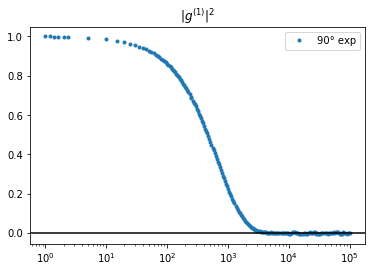

In [3]:
from MultiAngleDls import multiAngleDls

filelist = ['test_data/PS_200nm_90degree.dat']
data = multiAngleDls(filelist, d_min=1, d_max=300, d_num=50)
data.plotOriginalData()  

In [4]:
model = pm.Model()

tau = data.dlsDataList[0].tau * 1e-6
g1square_exp = data.dlsDataList[0].g1square
M = tau.size

# 构建 prior
from pymc3.distributions.continuous import BoundedContinuous
from pymc3.distributions.dist_math import bound

# 这里试着建立一个指数分布
class prior(BoundedContinuous):
    def __init__(self, lower=0, lam=1, *args, **kwargs):
        self.lower = lower = tt.as_tensor_variable(lower)
        self.lam = lam = tt.as_tensor_variable(lam)

        super().__init__(lower=lower,  *args, **kwargs)

    def logp(self, value):
        # value here is gamma
        lower = self.lower
        lam = self.lam
        return bound( -lam*(value-lower), value >= lower)


# 构建 likelihood
from pymc3.distributions import Continuous

testg1square = np.exp(-1*100*tau)**2
class likelihood(Continuous):

    def __init__(self, g1square_theo=testg1square, M=200, *args, **kwargs):
        self.g1square_theo = g1square_theo = tt.as_tensor_variable(g1square_theo)
        self.M = M = tt.as_tensor_variable(M)

        super().__init__(*args, **kwargs)

    def logp(self, value):
        # value here is g1square
        g1square_theo = self.g1square_theo
        M = self.M
        return -M/2 * tt.log( tt.sum( (value - g1square_theo)**2 ) )

kb = 1.38064852e-23                                 # Boltzmann Constant
theta = data.dlsDataList[0].angle / 180 * np.pi     # rad
Lambda = data.dlsDataList[0].wavelength * 1e-9      # in meter
T = data.dlsDataList[0].temperature                 # in Kelvin
eta = data.dlsDataList[0].viscosity * 1e-3          # viscosity, in Pa.s
n =data.dlsDataList[0].RI_liquid
Int = data.dlsDataList[0].intensity                 # intensity, should be cps

with model:
    d = prior('d', lower=10, lam=0.01, testval=50)

    gamma0 = (16 * np.pi * n**2 * kb * T)/(3 * Lambda**2 * eta) * np.sin(theta/2)**2
    g1square_theo = tt.exp(-gamma0/(d*1e-9)*tau)**2

    like = likelihood('like', g1square_theo=g1square_theo, M=M, shape=(M,1), testval=testg1square, observed=g1square_exp)


In [10]:
with model:
    step = pm.NUTS()
    trace = pm.sample(1000, step=step, cores=12, chains=12, tune=50000, discard_tuned_samples=True)
trace['d'].shape

Multiprocess sampling (12 chains in 12 jobs)
NUTS: [d]


Sampling 12 chains for 50_000 tune and 1_000 draw iterations (600_000 + 12_000 draws total) took 129 seconds.
The acceptance probability does not match the target. It is 0.6986846360514053, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6698501317437753, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7069394125749614, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8837622287589366, but should be close to 0.8. Try to increase the number of tuning steps.


(12000,)

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
d,221.138,0.165,220.831,221.451,0.002,0.002,5520.0,5520.0,5508.0,8482.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb52e67fd90>,
      dtype=object)

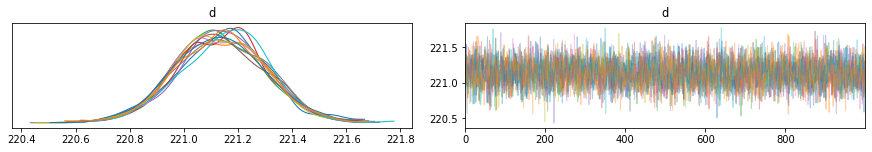

In [12]:
az.plot_trace(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb52d188fd0>],
      dtype=object)

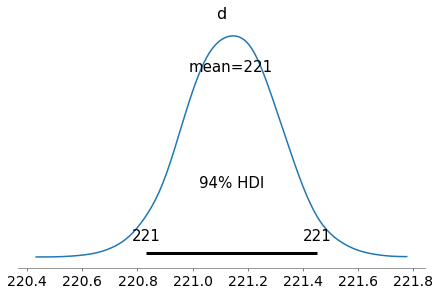

In [13]:
az.plot_posterior(trace)